<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#模型-(Model)" data-toc-modified-id="模型-(Model)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>模型 (Model)</a></span></li><li><span><a href="#训练算法-(Training-Algorithm)" data-toc-modified-id="训练算法-(Training-Algorithm)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>训练算法 (Training Algorithm)</a></span></li><li><span><a href="#加载数据-(Loading-Data)" data-toc-modified-id="加载数据-(Loading-Data)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>加载数据 (Loading Data)</a></span></li><li><span><a href="#训练-(Training)" data-toc-modified-id="训练-(Training)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>训练 (Training)</a></span></li><li><span><a href="#分析-(Analysis)" data-toc-modified-id="分析-(Analysis)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>分析 (Analysis)</a></span></li><li><span><a href="#保存模型-(Save-Model)" data-toc-modified-id="保存模型-(Save-Model)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>保存模型 (Save Model)</a></span></li></ul></div>

# 模型 (Model)

In [206]:
import torch 
import torch.nn as nn
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self,class_num=45):
        super(ConvNet, self).__init__()
                
        self.convs = nn.Sequential(          #99*99
            nn.Conv2d(1,48, kernel_size=5, stride=1, padding=2), #99*99
            nn.BatchNorm2d(48),
            #nn.Dropout2d(p=0.8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),  #33*33
            
            nn.Conv2d(48, 48, kernel_size=5, stride=2, padding=2), #17*17
            nn.BatchNorm2d(48),
            #nn.Dropout2d(p=0.8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2), #8*8
           
        )
        
        
        self.convs_red = nn.Sequential(          #99*99
            nn.MaxPool2d(kernel_size=6, stride=5, padding=1),  #20*20
            
            nn.Conv2d(1,32, kernel_size=6, stride=2, padding=3), #11*11
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.AvgPool2d(kernel_size=3, stride=2), #5*5
        )
        
        self.convs_grad = nn.Sequential(          #99*99
            nn.Conv2d(1,48, kernel_size=5, stride=1, padding=2), #99*99
            nn.BatchNorm2d(48),
            #nn.Dropout2d(p=0.8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),  #33*33
            
            nn.Conv2d(48, 48, kernel_size=5, stride=2, padding=2), #17*17
            nn.BatchNorm2d(48),
            #nn.Dropout2d(p=0.8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2), #8*8
           
        )
        
        self.fc_ratio = nn.Sequential(
            nn.Linear(1, 512),
            nn.Sigmoid()
        )
              
               
        self.fc = nn.Sequential(
            nn.Linear(8*8*48+5*5*32+8*8*48+512, class_num),
            nn.Sigmoid(),
            #nn.Linear(64, class_num),
        )
        
       
        
           
    def forward(self, x, r):
        y1 = self.convs(x[:,[1],:,:])
        y1 = y1.view(y1.size(0), -1)
        
        
        y2 = self.convs_red(x[:,[0],:,:])
        y2 = y2.view(y2.size(0), -1)
        
        y3 = self.convs_grad(x[:,[2],:,:])
        y3 = y3.view(y3.size(0), -1)
        
        y4 = self.fc_ratio(r)
        
        ya = torch.cat((y1,y2,y3,y4),1)
        
        out = self.fc(ya)
        #out2 = self.fc_red(out_red1.view(out_red1.size(0),-1))*0
             
        
        return out

# 训练算法 (Training Algorithm)

In [149]:
from tqdm import tqdm_notebook as tqdm
# Train the model
def train(model,loader,eloader,criterion,optimizer,num_epochs,device,state):
    model.train()
    total_step = len(train_loader)
    
    best_score = 10
    
    for epoch in range(num_epochs):
        
        tloss = []
        
        for i, (images,ratios,labels,_) in enumerate(loader):
            images = images.to(device)
            ratios = ratios.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images,ratios)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tloss.append(loss.item())
        
        tloss = np.mean(tloss)
        vloss = val(model,eloader,criterion,device)
        
        if vloss<best_score:
            best_score = vloss
        else:
            break
        
        print ('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}/{:.4f} ' 
                   .format(epoch+1, num_epochs, i+1, total_step, tloss, vloss))
        
        '''
        if vloss<state["best_score"]:
            state['best_score'] = vloss
            checkpoint = {
                    'state_dict': model.state_dict(),
                    'state': state
            }
            
            torch.save(checkpoint, state['save_path'])
        else:
            model.load_state_dict(torch.load(state['save_path'])['state_dict'])
            state['lr'] *= state['lr_decay']
            
            optimizer = torch.optim.Adam(model.parameters(), lr=state['lr'])
            print('* load previous best model: {}'.format(state["best_score"]))
            print('* model lr:{} '.format(state['lr']))
            if state['lr'] < state['min_lr']:
                print('* training over, best score: {}'.format(state["best_score"]))
                break
        '''
        

        

# Test the model
def val(model,loader,criterion,device):
    with torch.no_grad():
        losses = []
        for (images,ratios,labels,_) in loader:
            images = images.to(device)
            ratios = ratios.to(device)
            labels = labels.to(device)
            
            outputs = model(images,ratios)
            loss = criterion(outputs, labels)
            
            losses.append(loss.item())
            
        return np.mean(losses)

# Test the model
def test(model,loader,device):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        
        gt = []
        pr = []
        
        for i,tl in enumerate(loader):
                        
            gt.append([])
            pr.append([])
            for (images,ratios,labels,angles) in tl:
                images = images.to(device)
                ratios = ratios.to(device)
                labels = labels.to(device)

                outputs = model(images,ratios)

                outputs = outputs

                gt[-1].append(angles.numpy())
                pr[-1].append(outputs.detach().cpu().numpy())

            gt[-1] = np.concatenate(gt[-1],axis=0)
            pr[-1] = np.concatenate(pr[-1],axis=0)
        
        pr = np.stack(pr,axis=2)
        
        pr_max = np.max(pr,axis=1,keepdims=True)
        #pr = pr/pr_max
        
        gt = np.stack(gt,axis=1)
        #assert(np.max(np.std(gt,axis=1))>1e-5)
        
    return gt[:,0],np.mean(pr,axis=2),pr
    

In [284]:
import numpy as np

class_num = 360
idx = np.arange(class_num)
mn = np.mean(idx)
rg = np.max(idx)

idx = (idx-mn)/rg*2

pdf = np.exp(-np.power(idx,2)/0.005).astype(np.float32)
pdf = np.hstack((pdf[int(class_num/2):],pdf[:int(class_num/2)]))

In [285]:
pdf.shape

(360,)

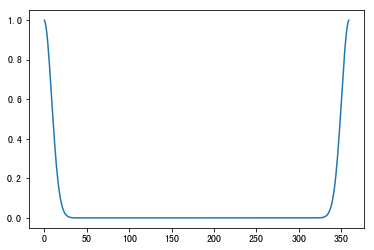

In [286]:
import matplotlib.pyplot as plt

plt.plot(pdf)
plt.show()

In [287]:
def angle2label(ag,pdf):
    
    class_num = len(pdf)
    
    csG = 360/class_num
        
    idx = int(np.floor(ag/csG))
    
    l = len(pdf)
        
    label = np.hstack((pdf[l-idx:],pdf[:l-idx]))
    
    return label
    
        
        
def label2angle(lb):
    class_num = len(lb)
    csG = 360/class_num
    
    idm = np.argmax(lb)
    

    return idm*csG+csG/2


# 加载数据 (Loading Data)

In [288]:
import pickle
import numpy as np


with open('data/gray_aug_data.dat','rb') as f:
    data = pickle.load(f)
    

In [289]:
import torch 


data['train_l'] = np.vstack([angle2label(l,pdf) for l in data['train_a']])
data['train_r'] = np.expand_dims(data['train_r'],axis=1)

data['test_l'] = []
for i in range(len(data['test_x'])):
    data['test_l'].append(np.vstack([angle2label(l,pdf) for l in data['test_a'][i]]))
    data['test_r'][i] = np.expand_dims(data['test_r'][i],axis=1)

channel = data['train_x'].shape[-1]
im_temp = data['train_x'].reshape(-1,channel)

maxv = np.max(im_temp,0)
minv = np.min(im_temp,0)
meanv = np.mean([maxv,minv])
    
max_r = np.max(data['train_r'])
min_r = np.min(data['train_r'])
mean_r = np.mean([max_r,min_r])
    
data['train_x'] = (data['train_x']-meanv)/(maxv-minv)+0.5
data['train_x'] = torch.tensor(np.transpose(data['train_x'],(0,3,1,2)),dtype=torch.float32)
data['train_a'] = torch.tensor(data['train_a'],dtype=torch.float32)
data['train_l'] = torch.tensor(data['train_l'],dtype=torch.float32)

data['train_r'] = 2*(data['train_r']-mean_r)/(max_r-min_r)
data['train_r'] = torch.tensor(data['train_r'],dtype=torch.float32)

for i in range(len(data['test_x'])):
    data['test_x'][i] = (data['test_x'][i]-meanv)/(maxv-minv)+0.5
    data['test_x'][i] = torch.tensor(np.transpose(data['test_x'][i],(0,3,1,2)),dtype=torch.float32)
    data['test_a'][i] = torch.tensor(data['test_a'][i],dtype=torch.float32)
    data['test_l'][i] = torch.tensor(data['test_l'][i],dtype=torch.float32)
    
    data['test_r'][i] = 2*(data['test_r'][i]-mean_r)/(max_r-min_r)
    data['test_r'][i] = torch.tensor(data['test_r'][i],dtype=torch.float32)



In [290]:
meanv,maxv,minv

(0.46275239536184687,
 array([0.99601961, 1.        , 0.78049476]),
 array([0., 0., 0.]))

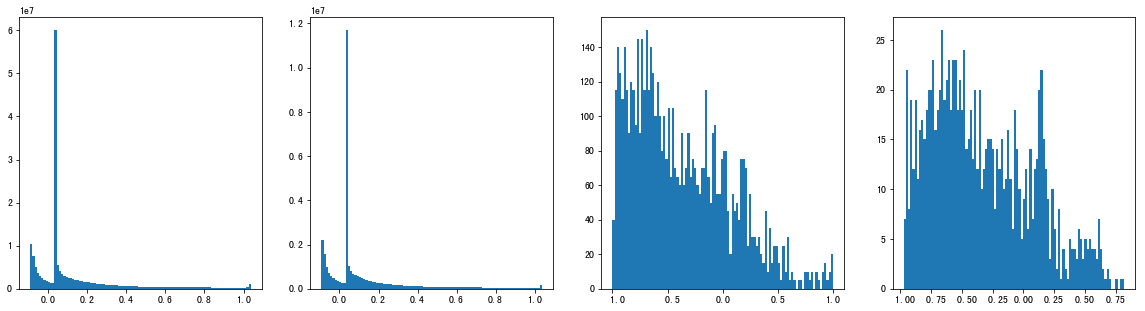

In [291]:
_,axes = plt.subplots(ncols=4,figsize=(20,5))
axes[0].hist(data['train_x'].view(-1),bins=100)
axes[1].hist(data['test_x'][0].view(-1),bins=100)
axes[2].hist(data['train_r'].view(-1),bins=100)
axes[3].hist(data['test_r'][0].view(-1),bins=100)
plt.show()

In [292]:
data['train_x'].shape,data['train_l'].shape,data['train_r'].shape,data['train_a'].shape

(torch.Size([5895, 3, 100, 100]),
 torch.Size([5895, 360]),
 torch.Size([5895, 1]),
 torch.Size([5895]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

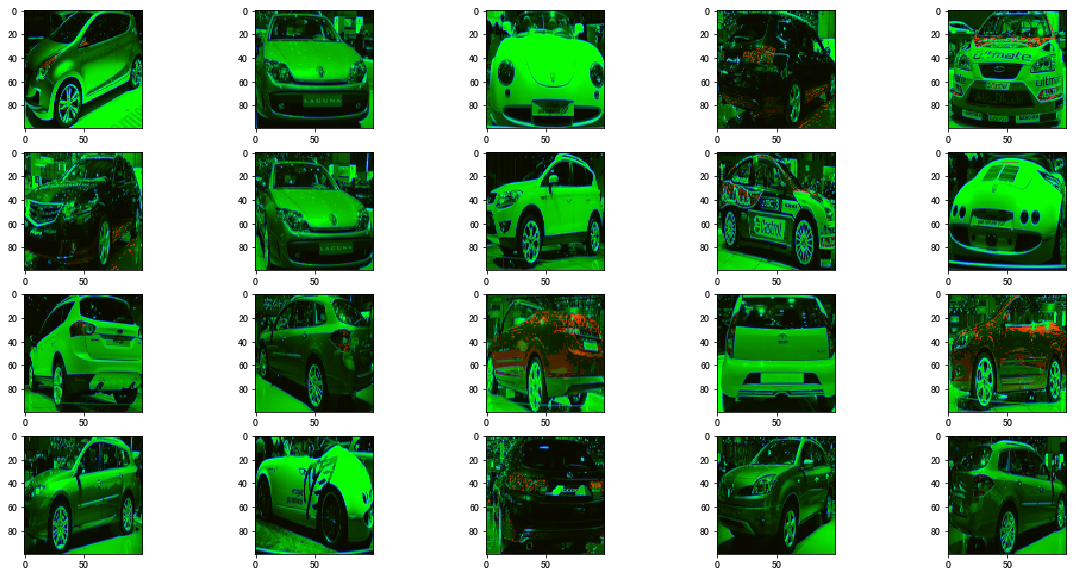

In [293]:
import matplotlib.pyplot as plt

figures,axes = plt.subplots(nrows=4,ncols=5,figsize=(20,10))

idx = np.random.permutation(np.size(data['train_x'],0))

for i,ax in zip(idx,axes.reshape(20)):
    if data['train_x'].size(1)==3:
        ax.imshow(data['train_x'][i,:,:,:].permute((1,2,0)))
    else:
        ax.imshow(data['train_x'][i,1,:,:])
    
    
plt.show()

# 训练 (Training)

In [294]:
import torch.utils.data
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Hyper parameters
num_epochs = 20
batch_size = 100

state = {'lr':0.001,
         'lr_decay':0.5,
         'min_lr':1e-5,
         'best_score':100,
         'save_path':'model/cnn.cp'}



# MNIST dataset
train_dataset = torch.utils.data.TensorDataset(data['train_x'],
                                               data['train_r'],
                                               data['train_l'],
                                               data['train_a'])

enum = int(len(train_dataset)*0.1)
nind = torch.randperm(len(train_dataset))

eval_dataset = torch.utils.data.Subset(train_dataset,nind[:enum])
train_dataset = torch.utils.data.Subset(train_dataset,nind[enum:])

print(len(train_dataset),len(eval_dataset))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)



eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

test_dataset = []
test_loader = []
for i in range(len(data['test_x'])):
    test_dataset.append(torch.utils.data.TensorDataset(data['test_x'][i],
                                                  data['test_r'][i],
                                                  data['test_l'][i],
                                                  data['test_a'][i]))
    
    test_loader.append(torch.utils.data.DataLoader(dataset=test_dataset[i],
                                                   batch_size=batch_size, 
                                                   shuffle=False))



5306 589


In [295]:
model = ConvNet(class_num=class_num).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [296]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model,train_loader,eval_loader,criterion,optimizer,100,device,state)

Epoch [1/100], Step [54/54], Loss: 0.0476/0.0442 
Epoch [2/100], Step [54/54], Loss: 0.0442/0.0442 
Epoch [3/100], Step [54/54], Loss: 0.0442/0.0442 
Epoch [4/100], Step [54/54], Loss: 0.0442/0.0442 
Epoch [5/100], Step [54/54], Loss: 0.0442/0.0442 
Epoch [6/100], Step [54/54], Loss: 0.0442/0.0442 
Epoch [7/100], Step [54/54], Loss: 0.0442/0.0442 
Epoch [8/100], Step [54/54], Loss: 0.0442/0.0442 
Epoch [9/100], Step [54/54], Loss: 0.0442/0.0441 
Epoch [10/100], Step [54/54], Loss: 0.0439/0.0432 
Epoch [11/100], Step [54/54], Loss: 0.0380/0.0270 
Epoch [12/100], Step [54/54], Loss: 0.0170/0.0112 
Epoch [13/100], Step [54/54], Loss: 0.0086/0.0060 
Epoch [14/100], Step [54/54], Loss: 0.0048/0.0041 
Epoch [15/100], Step [54/54], Loss: 0.0033/0.0031 
Epoch [16/100], Step [54/54], Loss: 0.0026/0.0025 
Epoch [17/100], Step [54/54], Loss: 0.0021/0.0022 
Epoch [18/100], Step [54/54], Loss: 0.0018/0.0019 
Epoch [19/100], Step [54/54], Loss: 0.0015/0.0018 
Epoch [20/100], Step [54/54], Loss: 0.00

In [297]:
gt,pr,prs = test(model,test_loader,device)


pr_a = np.zeros(np.size(pr,0),dtype=np.float32)

for i in range(np.size(pr,0)):
    pr_a[i] = label2angle(pr[i,:])

angle_error = np.abs(gt-pr_a)

angle_error = np.min(np.vstack((360-angle_error,angle_error)),axis=0)

n160 = np.where(angle_error>140)

print(f'mean:{np.mean(angle_error)}, median:{np.median(angle_error)},n160:{len(n160[0])}')

mean:9.280474662780762, median:3.5,n160:25


[173.92857 174.5     174.73077 175.22726 176.07143 176.29645 178.32353
 178.5     179.4823  179.92857]


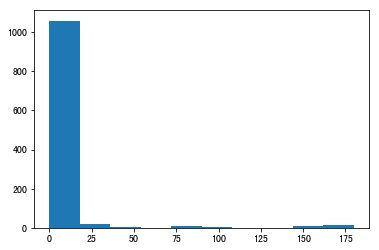

In [298]:
angle_sort = np.sort(angle_error)
print(angle_sort[-10:])

plt.hist(angle_error)
plt.show()

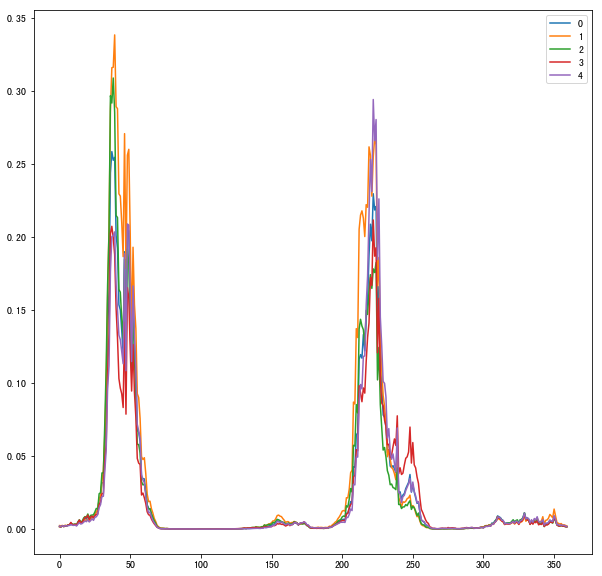

true:218.57142639160156,pred:38.5


In [299]:
idx = np.argsort(angle_error)

plt.figure(figsize=(10,10))

lid = -1

for i in range(np.size(prs,2)):
    plt.plot(prs[idx[lid],:,i], label=f'{i}')

plt.legend(loc='upper right')
plt.show()

print(f'true:{gt[idx[lid]]},pred:{pr_a[idx[lid]]}')

# 分析 (Analysis)

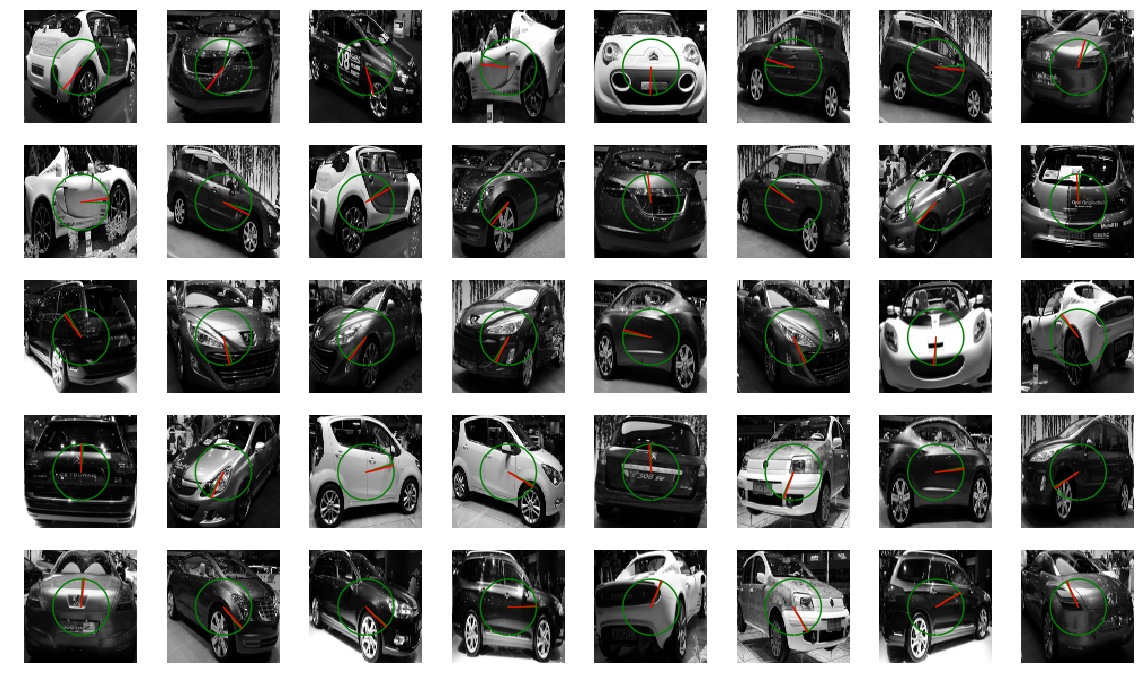

In [327]:
idx = np.argsort(angle_error)
_,axes = plt.subplots(ncols =8,nrows=5,figsize=(20,12))

ww = test_dataset[0][0][0].shape[1]/2

t = np.arange(0,2*np.pi,0.1)
cir = np.vstack((-ww/2*np.sin(t)+ww,ww/2*np.cos(t)+ww))

for i,ax in enumerate(axes.reshape(40)):
    im_id = idx[-i*20-1]
    im = test_dataset[0][im_id][0]
    im = im[1,:,:]
    ax.imshow(im,cmap='gray')
    
    ax.plot(cir[0,:],cir[1,:],color='green')
    
    ang_true = gt[im_id]
    ang_pred = pr_a[im_id]

    x1,y1,x2,y2 = ww,ww,-ww/2*np.sin(np.deg2rad(ang_true))+ww,ww/2*np.cos(np.deg2rad(ang_true))+ww
    ax.plot([x1,x2],[y1,y2],color="green",)
    
    x1,y1,x2,y2 = ww,ww,-ww/2*np.sin(np.deg2rad(ang_pred))+ww,ww/2*np.cos(np.deg2rad(ang_pred))+ww
    ax.plot([x1,x2],[y1,y2],color="red")
    
    ax.axis('off')

plt.show()


# 保存模型 (Save Model)

In [307]:
torch.save(model.state_dict(), 'model/best.mdl')